# Датасет Titanic from Kaggle. 
Необходимо построить модель, которая предскажет выживших после катастрофы пассажиров. 

In [1]:
# Titanic Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

C:\Users\aab\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\aab\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('train.csv', sep=',', index_col = 0,  encoding = "ISO-8859-1", low_memory=False)
tf = pd.read_csv('test.csv', sep=',', index_col = 0,  encoding = "ISO-8859-1", low_memory=False)

print(f'Training set dimension: {df.shape}\n')
print(f'Test set dimension: {tf.shape}\n')


Training set dimension: (891, 11)

Test set dimension: (418, 10)



In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Описательные статистики
desc = df.describe(include = 'all')
desc.loc['NaN count'] = df.isna().sum()
uniques = df.apply(lambda x: x.nunique())
desc.loc['uniques'] = uniques
desc.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


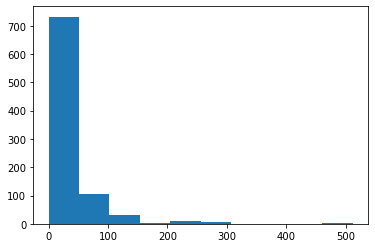

In [5]:
# Подобные гистограммы можно строить для каждой переменной, чтобы оценить ее распределение
# Построим гистограмму для переменной "Цена билета"
fig, axs = plt.subplots(1, 1, sharey = False, tight_layout = False)
axs.hist(df['Fare'].dropna(), bins = 10);

In [6]:
# Заполним пропуски подходящими значениями 
# "Age" - median; "Embarked" - "S"
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna('S')

df['Cabin'].fillna(0, inplace = True)
df['Cabin'][df['Cabin'] != 0] = 1


In [7]:
# Оцифруем категорийные переменные
df = df.replace({'Sex' : { 'male' : 0, 'female' : 1}, 'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}})
df['Cabin'] = df['Cabin'].astype('int64')
df['Embarked'] = df['Embarked'].astype('int64')
df.reset_index(drop = True, inplace = True)
#df.describe(include = 'all')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,0


<Figure size 432x288 with 0 Axes>

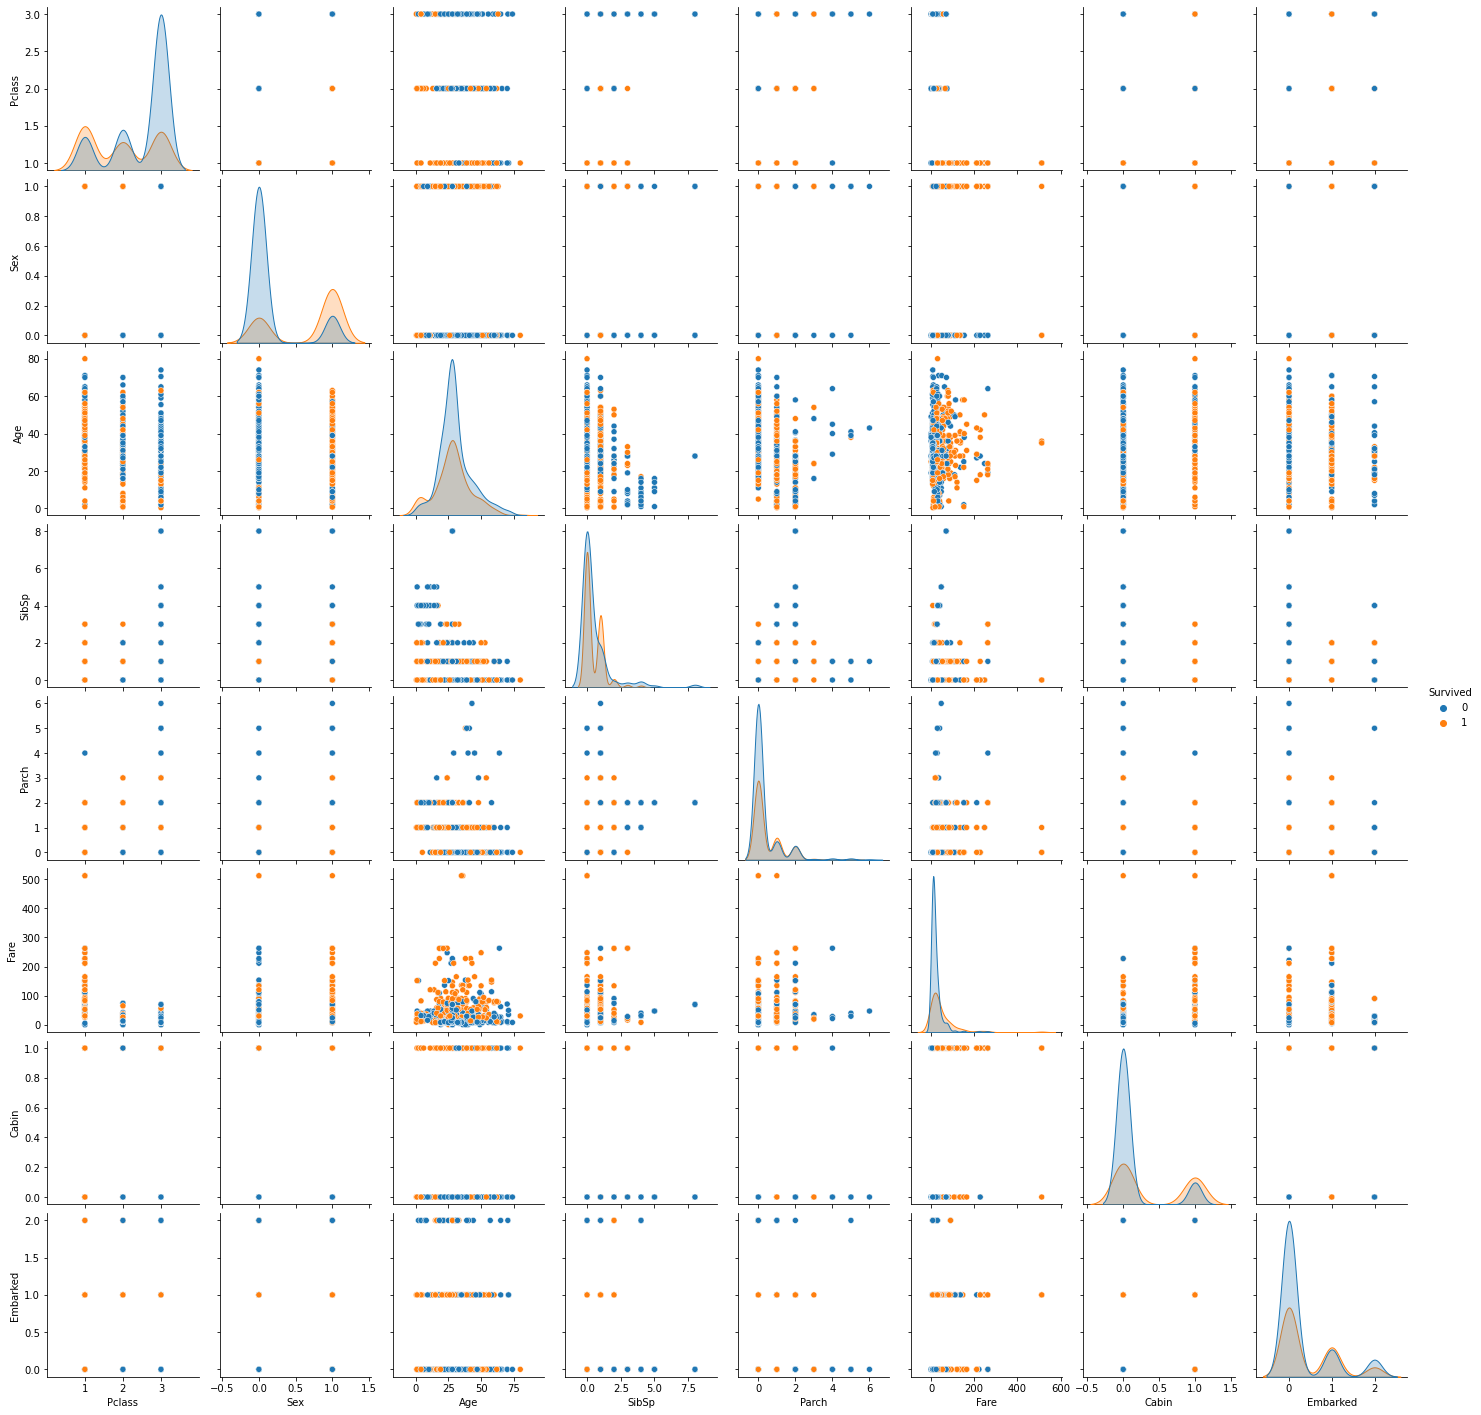

In [8]:
# Построим парные диаграммы рассеяния для всех переменных, а значение целевой переменной выделим цветом
# Синий цвет - погибшие пассажиры, рыжий - выжившие
plt.figure()
sns.pairplot(data = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Survived']], hue = 'Survived', dropna = True);

Из диаграмм рассеяния видно, что некоторые переменные будут в значительной степени влиять на целевую переменную - например, пол пассажира и класс его/ее каюты. 

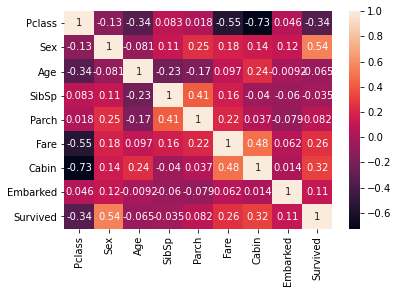

In [9]:
# Построим тепловую карту признаков, чтобы определить, нет ли в датасете сильно коррелирующих между собой переменных
sns.heatmap(df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Survived']].corr(), annot = True);


Очень больших корреляций с абсолютным значением от 0.8 и выше нет, поэтому все признаки можно взять в модель

In [10]:
# Создаем датафреймы признаков и целевой переменной
X = df.copy()
y = pd.DataFrame(df['Survived'])
X.drop(['Survived', 'Name', 'Ticket'], axis = 1, inplace = True)

In [11]:
# кодируем в отдельные признаки категориальный признак "Embarked"
X = pd.get_dummies(X, columns = ['Embarked'])

In [12]:
# pip3 install numpy==1.23.1
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

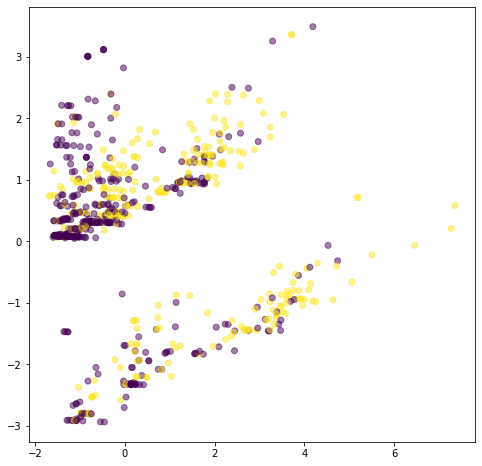

In [14]:
# Применим алгоритм сокращения размерности до 2 и посмотрим диаграмму рассеяния
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components = 2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca.shape

plt.figure(figsize = (8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y['Survived'], alpha = 0.5);

На диаграмме рассеяния целевая переменная неплохо разделилась на разные группа, поэтому можно ожидать приличного результата моделирования.

In [26]:
# попробуем обучить базовую модель
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
print(f'Train shape : {X_train.shape}')
print(f'Test shape : {X_test.shape}')


from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score #, metrics   
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


# Для обучения используем функцию, в которую удобно будет передавать модель и ее параметры обучения
def modelfit(alg, X_train, y_train, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    y_train = np.ravel(y_train)
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label = y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds,
            metrics = 'auc', early_stopping_rounds = early_stopping_rounds)
        alg.set_params(n_estimators = cvresult.shape[0])
        print(cvresult.shape)
    
    alg.fit(X_train, y_train, eval_metric = 'auc')
        
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending = False)
    feat_imp.plot(kind = 'bar', title = 'Feature Importances')
    plt.ylabel('Feature Importance Score')

Train shape : (668, 10)
Test shape : (223, 10)


(28, 4)

Model Report
Accuracy : 0.8668
AUC Score (Train): 0.935271
Accuracy on train set: 0.867
Accuracy on test set: 0.839


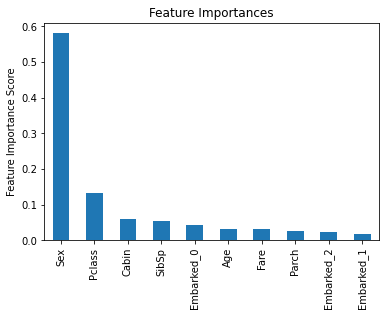

In [27]:
# Первый прогон со стандартными параметрами
xgb1 = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 5, min_child_weight = 1, 
                     gamma = 0, subsample = 0.8, colsample_bytree = 0.8, objective = 'binary:logistic',
                     nthread = 4, scale_pos_weight = 1, seed = 0)
modelfit(xgb1, X_train, y_train)


print('Accuracy on train set: {:.3f}'.format(xgb1.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(xgb1.score(X_test, y_test)))

На столбчатой диаграмме удобно смотреть ценность признаков для модели. Как было понятно из диаграмм рассеяния признаков, пол и класс обслуживания пассажиров имеют определяющее влияние на целевую переменную. 

Дальше код можно не смотреть. В нем происходит подбор тестирование разнообразных моделей и их параметров. Никаких "прорывных" результатов там нет. 
Ячейка импортирована из *.py файла, поэтому так странно выглядит. 

In [ ]:
# Второй прогон - подбираем max_depth и min_child_weight

param_test1 = {
 'max_depth' : np.arange(3,10,1),
 'min_child_weight' : np.arange(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 17, max_depth = 5,
 min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
 objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 0), 
 param_grid = param_test1, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch1.fit(X_train, np.ravel(y_train))
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


# In[85]:


# Подбор параметра гамма
param_test3 = {
 'gamma':[i/10.0 for i in np.arange(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 17, max_depth = 7,
 min_child_weight = 2, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
 objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 0), 
 param_grid = param_test3, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch3.fit(X_train, np.ravel(y_train))
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


# In[86]:


xgb2 = XGBClassifier(learning_rate = 0.1, n_estimators = 17, max_depth=7, min_child_weight = 2, gamma = 0,
                     subsample = 0.8, colsample_bytree = 0.8, objective = 'binary:logistic', nthread = 4,
                     scale_pos_weight = 1, seed = 0)
modelfit(xgb2, X_train, y_train)


# In[87]:


# Подбор параметров субсэмплирования рядов и колонок
param_test4 = {
 'subsample':[i/10.0 for i in np.arange(6,10)],
 'colsample_bytree':[i/10.0 for i in np.arange(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 17, max_depth = 7,
                                                   min_child_weight = 2, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                   objective= 'binary:logistic', nthread = 4, scale_pos_weight = 1,seed = 0),
                        param_grid = param_test4, scoring='roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch4.fit(X_train, np.ravel(y_train))
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


# In[88]:


# Подбор параметра регуляризации
# Если средний score очень колеблется, то повторяем в более мелкой разбивке ближе к оптимальному параметру
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 17, max_depth = 7,
                                                   min_child_weight = 2, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                   objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 0),
                        param_grid = param_test6, scoring ='roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch6.fit(X_train, np.ravel(y_train))
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_


# In[90]:


param_test7 = {
 'reg_alpha':[1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 5e-4, 1e-4]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators = 17, max_depth = 7,
                                                   min_child_weight = 2, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                   objective= 'binary:logistic', nthread = 4, scale_pos_weight = 1,seed = 0),
                         param_grid = param_test7, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch7.fit(X_train, np.ravel(y_train))
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_


# In[91]:


xgb3 = XGBClassifier(learning_rate = 0.1, n_estimators = 17, max_depth = 7, min_child_weight = 2, gamma = 0, subsample = 0.8,
                     colsample_bytree = 0.8, reg_alpha = 1e-07, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1,
                     seed = 0)
modelfit(xgb3, X_train, y_train)


# In[92]:


xgb4 = XGBClassifier(learning_rate = 0.01, n_estimators = 1700, max_depth = 7, min_child_weight = 2, gamma = 0, subsample = 0.8,
                     colsample_bytree = 0.8, reg_alpha = 1e-07, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1,
                     seed = 0)
modelfit(xgb4, X_train, y_train)


# In[93]:


print('Accuracy on test set: {:.3f}'.format(xgb4.score(X_test, y_test)))


# In[94]:


# Training model on full set
modelfit(xgb4, X, y)


# In[95]:


# Making predictions
tf['Age'] = tf['Age'].fillna(tf['Age'].median())
tf['Embarked'] = tf['Embarked'].fillna('S')
tf['Cabin'].fillna(0, inplace=True)
tf['Cabin'][tf['Cabin'] != 0] = 1
tf = tf.replace({'Sex' : { 'male' : 0, 'female' : 1}, 'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}})
tf['Cabin'] = tf['Cabin'].astype('int64')
tf['Embarked'] = tf['Embarked'].astype('int64')
ans_ind = tf.index
tf.reset_index(drop = True, inplace = True)
tf.drop(['Name', 'Ticket'], axis = 1, inplace = True)
tf = pd.get_dummies(tf, columns = ['Embarked'])
tf.head()


# In[96]:


xg_predictions = xgb4.predict(tf)


# In[97]:


ans = pd.DataFrame(ans_ind)
ans['Survived'] = pd.Series(xg_predictions)
ans.head()
ans.to_csv('My_Titanic.csv', index = False)


# In[20]:


# Logistic Regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_train, y_train)
print('Accuracy on train set: {:.3f}'.format(LR.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(LR.score(X_test, y_test)))


# In[21]:


# Random Forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators = 100,
                            random_state = 0, n_jobs = -1, max_depth = 5).fit(X_train, y_train)

print('Accuracy on train set: {:.3f}'.format(RF.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(RF.score(X_test, y_test)))


# In[22]:


#GBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)
print('Accuracy on train set: {:.3f}'.format(GB.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(GB.score(X_test, y_test)))


# In[23]:


#Cross-Validation
from sklearn.model_selection import cross_val_score
GBs = GradientBoostingClassifier(random_state = 0)

scores = cross_val_score(GBs, X, y, cv = 5)
print(f'Значения правильности перекрестной проверки: {scores}')


# In[24]:


# Support Vector Machine
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print('Accuracy on train set: {:.3f}'.format(svm.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.3f}'.format(svm.score(X_test_scaled, y_test)))


# In[25]:


from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv = 5)
grid_search.fit(X_train_scaled, np.ravel(y_train))

print('Accuracy on train set: {:.3f}'.format(grid_search.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.3f}'.format(grid_search.score(X_test_scaled, y_test)))
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cv-score: {grid_search.best_score_}')


# In[26]:


results = pd.DataFrame(grid_search.cv_results_)


# In[27]:


results.head()


# In[28]:


scores = np.array(results.mean_test_score).reshape(6,6)


# In[29]:


fig, ax = plt.subplots()
im = ax.imshow(scores)
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(param_grid['gamma'])
ax.set_yticklabels(param_grid['C'])
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, round(scores[i, j],2),
                       ha="center", va="center", color="w")

plt.show


# In[32]:


from sklearn import cross_validation, metrics
def modelfit(alg, X_train, y_train, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X_train, np.ravel(y_train), cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


# In[33]:


#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns]
gbm0 = GradientBoostingClassifier(random_state = 0)
modelfit(gbm0, X_train, y_train, predictors)


# In[34]:


print('Accuracy on test set: {:.3f}'.format(gbm0.score(X_test, y_test)))


# In[45]:


# Первый прогон модели:
# Подбираем оптимальное количество деревьев
# нормальный learning_rate = 0.1
# min_samples_split = ~0.5-1% тренировочной выборки. Чем больше дисбаланс классов, тем ниже процент. 
# min_samples_leaf = интуитивно, примерно в 10 раз меньше,чем min_samples_split
# max_depth - от 5 до 8, тем меньше, чем меньше наблюдений и факторов

param_test1 = {'n_estimators':np.arange(20,121,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, min_samples_split = 3,
                                  min_samples_leaf = 5, max_depth = 5, max_features = 'sqrt', subsample = 0.8, random_state = 0), 
                       param_grid = param_test1, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch1.fit(X_train,np.ravel(y_train))


# In[46]:


gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


# In[47]:


modelfit(gsearch1.best_estimator_, X_train, y_train, predictors)


# In[48]:


# Второй прогон модели 
# подбираем max_depth и min_samples_split
# оптимальный max_depth от 5 до 8, но мы возьмем более широкий диапазон
# min_samples_split = ~0.5-1% тренировочной выборки, мы возьмем более широкий диапазон 

param_test2 = {'max_depth':np.arange(3,16,1), 'min_samples_split':np.arange(3,100,3)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 40,
                                                max_features = 'sqrt', subsample = 0.8, random_state = 0), 
                       param_grid = param_test2, scoring = 'roc_auc',n_jobs = -1, iid = False, cv = 5)
gsearch2.fit(X_train,np.ravel(y_train))


# In[49]:


gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


# In[50]:


modelfit(gsearch2.best_estimator_, X_train, y_train, predictors)


# In[54]:


# Третий прогон модели 
# подбираем min_samples_leaf

param_test3 = {'min_samples_split': np.arange(30, 100, 5), 'min_samples_leaf' : np.arange(1,31,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 40, 
                                                               max_depth = 5, max_features='sqrt', 
                                                               subsample = 0.8, random_state = 0), 
param_grid = param_test3, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch3.fit(X_train,np.ravel(y_train))
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


# In[55]:


modelfit(gsearch3.best_estimator_, X_train, y_train, predictors)


# In[57]:


# Четвертый прогон - подбираем max_features
#

param_test4 = {'max_features': np.arange(2, 11, 1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 40, max_depth = 5, 
                            min_samples_split = 75, min_samples_leaf = 1, subsample = 0.8, random_state=0),
                        param_grid = param_test4, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch4.fit(X_train,np.ravel(y_train))


# In[58]:


gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


# In[59]:


modelfit(gsearch4.best_estimator_, X_train, y_train, predictors)


# In[64]:


# Пятый прогон - subsample

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 40, max_depth = 5, 
                            min_samples_split = 75, min_samples_leaf = 1, subsample = 0.8, random_state = 0),
                        param_grid = param_test5, scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 5)
gsearch5.fit(X_train,np.ravel(y_train))


# In[65]:


gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_


# In[66]:


modelfit(gsearch5.best_estimator_, X_train, y_train, predictors)


# In[67]:


# Шестой прогон - снижаем learning_rate в 2 раза, поднимаем количество деревьев в 2 раза

gbm_tuned_1 = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 80, max_depth = 5, min_samples_split = 75, 
                                         min_samples_leaf = 1, subsample = 0.75, random_state = 0)
modelfit(gbm_tuned_1, X_train,y_train, predictors)


# In[68]:


# Седьмой прогон - снижаем learning_rate в 10 раз, соответстенно поднимаем в 10 раз количество деревьев

gbm_tuned_2 = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 400, max_depth = 5, min_samples_split = 75, 
                                         min_samples_leaf = 1, subsample = 0.75, random_state = 0)
modelfit(gbm_tuned_2, X_train,y_train, predictors)


# In[69]:


# Восьмой прогон - снижаем learning_rate в 20 раз, соответстенно поднимаем в 20 раз количество деревьев

gbm_tuned_3 = GradientBoostingClassifier(learning_rate = 0.005, n_estimators = 800, max_depth = 5, min_samples_split = 75, 
                                         min_samples_leaf = 1, subsample = 0.75, random_state = 0)
modelfit(gbm_tuned_3, X_train,y_train, predictors)


# In[70]:


print('Accuracy on test set: {:.3f}'.format(gbm_tuned_3.score(X_test, y_test)))


# In[77]:


GB = GradientBoostingClassifier(learning_rate = 0.005, n_estimators = 800, max_depth = 5, min_samples_split = 75,
                                min_samples_leaf = 1, subsample = 0.75, random_state = 0).fit(X_train, y_train)
print('Accuracy on train set: {:.3f}'.format(GB.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(GB.score(X_test, y_test)))


# In[ ]:




